In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,OneHotEncoder,Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import  matplotlib.pyplot as plt
# import os
# os.environ["PATH"] += os.pathsep + "D:\\Program Files (x86)\\Graphviz2.38\\bin\\"
# print(os.environ["PATH"])
import pydotplus

In [3]:
data = pd.read_csv('./modeldata1.csv',encoding="gbk")
data['target'] = data['是否逾期'].map({
    "是":1,
    "否":0
})
data = data.drop(['是否逾期'],axis=1)
data.shape

(1563, 30)

In [4]:
import numbers
allFeatures = list(data.columns)
allFeatures.remove('target')

numerical_var = []
for col in allFeatures:
    if len(set(data[col])) == 1:
        print('delete {} from the dataset because it is a constant'.format(col))
        del data[col]
        allFeatures.remove(col)
    else:
        uniq_valid_vals = [i for i in data[col] if i == i]
        uniq_valid_vals = list(set(uniq_valid_vals))
        if len(uniq_valid_vals) >= 6 and isinstance(uniq_valid_vals[0], numbers.Real):
            numerical_var.append(col)

categorical_var = [i for i in allFeatures if i not in numerical_var]
print(numerical_var)
print(categorical_var)

['closed_accounts', 'open_accounts', 'enquiry_alert', '人脸相似度', '年龄', '信用卡额度使用率', '信用卡数', '信用卡平均额度', '贷款数', '贷款平均额度', '平均分期金额', '平均期数', '90天内贷款查询次数', '180天内贷款查询次数', '120天内信用卡查询次数', '365天内信用卡查询次数', '历史近两年逾期最大天数', 'ULC33S', '近三个月逾期天数', 'G207O', 'dsr_before', '历史申请贷款查询数', '开户成功率', 'total_monthly_obligation']
['申请时段', 'grade', '电话使用时长', '分区', '身份证号首字母']


In [5]:
def preprocessing():
    
    #label = data['target']
    #data = data.drop(['target'],axis=1)
    #特征选择
    #考虑相关性，可以去除几个属性，但因为总体的属性不多，暂不处理
    #特征处理
    for i in range(len(numerical_var)):
        data[numerical_var[i]] = MinMaxScaler().fit_transform(data[numerical_var[i]].values.reshape(-1,1)).reshape(1,-1)[0]

    #处理离散值数值化
    for i in range(len(categorical_var)):
        if categorical_var[i] == "申请时段":
            data[categorical_var[i]] = [map_apply(s) for s in data["申请时段"].values]
            data[categorical_var[i]] = MinMaxScaler().fit_transform(data[categorical_var[i]].values.reshape(-1,1)).reshape(1,-1)[0]
        elif categorical_var[i] == "grade":
            data[categorical_var[i]] = [map_grade(w) for w in data['grade'].values]
            data[categorical_var[i]] = MinMaxScaler().fit_transform(data[categorical_var[i]].values.reshape(-1,1)).reshape(1,-1)[0]
        else:
            data[categorical_var[i]] = LabelEncoder().fit_transform(data[categorical_var[i]])
            #对于labelEncoder的情况下还需要进行归一化处理
            data[categorical_var[i]] = MinMaxScaler().fit_transform(data[categorical_var[i]].values.reshape(-1,1)).reshape(1,-1)[0]

    return data

def map_apply(s):
    d = dict([("0点",24),("1点",1),("2点",2),("3点",3),("4点",4),("5点",5),("6点",6),("7点",7),("8点",8),("9点",9),("10点",10),("11点",11),
             ("12点",12),("13点",13),("14点",14),("15点",15),("16点",16),("17点",17),("18点",18),("19点",19),("20点",20),("21点",21),
             ("22点",22),("23点",23)])
    return d.get(s,0)
def map_grade(w):
    d = dict([("AA",9),("BB",8),("CC",7),("DD",6),("EE",5),("FF",4),("GG",3),("HH",2),("II",1)])
    return d.get(w,0)


In [6]:
X = preprocessing()
Y = X['target']
X = X.drop(['target'],axis=1)
print(X)
print(Y)

          申请时段  grade  closed_accounts  open_accounts  enquiry_alert  \
0     0.869565  0.125         0.325581       0.294118       0.248908   
1     0.913043  0.125         0.023256       0.294118       0.275109   
2     0.521739  0.000         0.674419       0.352941       0.310044   
3     0.434783  0.000         0.465116       0.235294       0.253275   
4     0.391304  0.125         0.046512       0.294118       0.196507   
5     0.434783  0.000         0.302326       0.705882       0.327511   
6     0.521739  0.000         0.162791       0.352941       0.401747   
7     0.565217  0.375         0.046512       0.000000       0.096070   
8     0.869565  0.125         0.255814       0.411765       0.419214   
9     1.000000  0.000         0.116279       0.235294       0.266376   
10    0.434783  0.000         0.069767       0.352941       0.327511   
11    0.565217  0.000         0.162791       0.470588       0.358079   
12    0.608696  0.000         0.069767       0.411765       0.20

/Users/roy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)


In [28]:
from sklearn.metrics import accuracy_score,recall_score,f1_score,confusion_matrix,precision_score
def doMetrics(Y_true,Y_predict,clf_name):
    print(clf_name,"_Acc:",accuracy_score(Y_true,Y_predict))
    print(clf_name,"_precision_socre:",precision_score(Y_true,Y_predict))
    print(clf_name,"_recall:",recall_score(Y_true,Y_predict))
    print(clf_name,"_f1-score:",f1_score(Y_true,Y_predict))
    print(confusion_matrix(Y_true,Y_predict,labels=[0,1]))

(1094, 29)
115
(469, 29)
RandomForestClassifier _Acc: 0.769722814499
RandomForestClassifier _precision_socre: 0.241071428571
RandomForestClassifier _recall: 0.54
RandomForestClassifier _f1-score: 0.333333333333
[[334  85]
 [ 23  27]]


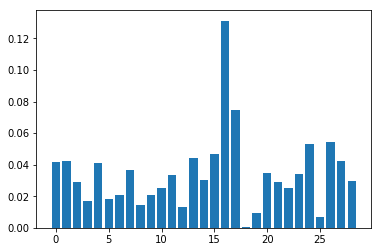

In [29]:
from sklearn.tree import DecisionTreeClassifier
print(X_train.shape)
print(Y_train.sum())
print(X_test.shape)
# tree = DecisionTreeClassifier(random_state=0, class_weight='balanced', min_weight_fraction_leaf=0.05,splitter='random')
# tree.fit(X_train,Y_train)
# tree.score(X_test,Y_test)
# Y_predict = tree.predict(X_test)
# doMetrics(Y_test,Y_predict,"DecisionTreeClassifier")
# print(tree.feature_importances_)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000,n_jobs=4,class_weight='balanced', min_weight_fraction_leaf=0.1)
rfc.fit(X_train,Y_train)
doMetrics(Y_test,rfc.predict(X_test),"RandomForestClassifier")
plt.bar(range(len(rfc.feature_importances_)),rfc.feature_importances_)
plt.show()

In [10]:
#(n_estimators=1000,n_jobs=4,class_weight='balanced', min_weight_fraction_leaf=0.1
from sklearn.model_selection import GridSearchCV
params = {
          'max_depth':range(1,20,1)
         }
clf = RandomForestClassifier(class_weight='balanced',n_jobs=-1)
gs = GridSearchCV(clf,params,cv=5,n_jobs=-1)
gs.fit(X,Y)
print(gs.best_params_)


{'max_depth': 14}


In [21]:
#使用降采样
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import confusion_matrix
bbc = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_jobs=-1,max_depth=14,class_weight='balanced'),
                                ratio='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_train, Y_train) 

y_pred = bbc.predict(X_test)
confusion_matrix(Y_test, y_pred)
doMetrics(Y_test,y_pred,"BalancedBaggingClassifier")

BalancedBaggingClassifier _Acc: 0.650319829424
BalancedBaggingClassifier _recall: 0.6
BalancedBaggingClassifier _f1-score: 0.267857142857
[[275 144]
 [ 20  30]]


In [12]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
#对决策树进行画图和输出
def plotTree(clf,clf_name,feature_names):
    dot_data = export_graphviz(clf,
                               out_file=None,
                               feature_names=feature_names,
                               class_names=["Good","Bad"],
                               filled=True,
                               rounded=True,
                               special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf(clf_name + ".pdf")
plotTree(tree,"tree",X_train.columns.values)
print("Done.")

NameError: name 'tree' is not defined